In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from pairwise.src.pairwise_fitter import Pairwise_fitter
from pairwise.src.pairwise_evaluator import Pairwise_evaluator
import importlib
import src.paper_utils as utils
import src.plot as myplot
import pairwise.src.pairwise_utils as pwutils


In [36]:
importlib.reload(myplot)
importlib.reload(utils)
importlib.reload(pwutils)

<module 'pairwise.src.pairwise_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots_pw/../../pairwise/src/pairwise_utils.py'>

In [15]:
nspin = 121
model_digits = list(range(10))

testdatas = [np.genfromtxt(utils.load_test_data(digit), dtype=int, delimiter=1) for digit in model_digits]
# ACE

pw_modname = "ACE"
outdir = "../data/OUTPUT/pairwise/OUTPUT_mod/4h_train5423/L0/"

pw_mods = [pwutils.get_pw_mod(i,nspin,outdir,fname="train-images-unlabeled-{}") for i in model_digits] # both models were stopped after 100 iterations of the ACE algorithm, 4k samples

pairwise_distrs = np.empty((len(model_digits),len(model_digits),len(testdatas[0])))
for i_dig, testdig in enumerate(testdatas):
    for i_md, mod in enumerate(pw_mods):
        pairwise_distrs[i_md,i_dig,:] = np.array([mod.calc_energy(state) for state in testdig])

# calculate parition function
traindatas = [np.genfromtxt(utils.load_test_data(digit, all_data_path="../data/INPUT_all/data/",fname="train-images-unlabeled-{}.dat"), dtype=int, delimiter=1) for digit in model_digits]
Zs = pwutils.partition_functions(traindatas,pw_mods)
pairwise_distrs = (np.exp(-1*pairwise_distrs)/ Zs[None,:,None]) # partition function

892 5423


In [28]:
pairwise_distrs.shape
max_decision_unit = np.argmax(pairwise_distrs,axis=0)
digit_accu = [1-np.count_nonzero(max_decision_unit[k,:] - k)/892 for k in range(10)]
np.vstack((np.arange(10), digit_accu)).T,  f"Grand mean={np.mean(digit_accu)}"

(array([[0.        , 0.83295964],
        [1.        , 0.96748879],
        [2.        , 0.95067265],
        [3.        , 0.88004484],
        [4.        , 0.89573991],
        [5.        , 0.88565022],
        [6.        , 0.92488789],
        [7.        , 0.84753363],
        [8.        , 0.882287  ],
        [9.        , 0.94170404]]),
 'Grand mean=0.9008968609865471')

In [29]:
# for every set of testimages, compute 

# the most likely label the NB classifier gave to each image (10, 892)
predicted_labels_per_image = max_decision_unit

# np.unique(arr, return_counts=True)
v, c = np.unique(predicted_labels_per_image, return_counts=True,axis=1)
# list of tuples: each tuple is each wrong label:count how often each label
unqs = [np.unique(arr, return_counts=True) for arr in predicted_labels_per_image]

idx_arr = np.zeros((10,10))
for i in range(10):
    idx_arr[i][unqs[i][0]] = unqs[i][1]

idx_arr /= 982

#
np.fill_diagonal(idx_arr, 0)
# np.fill_diagonal(idx_arr,idx_arr.max())
np.mean((1-idx_arr[3][5], 1-idx_arr[5][3]))
# 1-idx_arr

# unqs[i][0]

0.9506109979633401

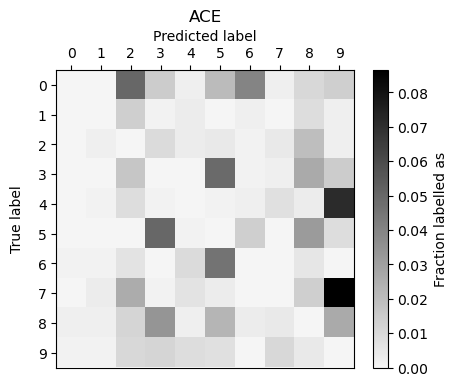

In [50]:
im = myplot.plot_confusion_matrix(idx_arr,10,logScale=False,cmap=myplot.cmap_to_gray("black",reverse=True), title="")#,title="Confusion matrix:\n MCM(n=5423) on test set")
plt.colorbar(im,shrink=.8).set_label("Fraction labelled as")
plt.title("ACE")
# plt.savefig("./img/confusion_testacc_ace.png",dpi=300, bbox_inches="tight")
plt.savefig("../paper_plots/img/ace_confmx.png", bbox_inches="tight", dpi=300)